# Deep Learning of the Extreme Value Index

Estimating the extreme value index, which describes the tail behavior of Pareto-type distributions, is a complex task and estimators usually depend on the choice of a threshold, above which the data can be used for statistical inference on extreme events.<br> 
More specifically, in extreme value analysis one considers observations from a distribution function $F$, which can be approximated by a Pareto distribution in the tail. This means that for $x$ large enough, $$ 1-F(x)\approx x^{-1/\gamma}, $$ for $\gamma>0$. The extreme value index $\gamma$ describes how likely extremely high observations $x$ are. The higher $\gamma$ the more likely are extreme outliers. <br>

The question I want to discuss here is: Can I train a network on random samples to determine the extreme value index without the selection of a threshold?

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import random

np.random.seed(42)
tf.set_random_seed(42)

In the following the training data is generated and the labels contain the value of the corresponding extreme value index $\gamma$. For the network to learn well it is very important to obtain training samples which represent a broad class of distributions. <br>
Since I am working on samples from heavy-tailed distributions, which can include extremely high values, I can not use the samples directly to train the network. Instead of the raw obervations I look at their logarithm. This trick leads to a more reasonable range of observed values and is also a natural thing to do in extreme value statistics, as it leads to an exponential approximation of the peak-over-threshold approach instead of a pareto approximation.

In [2]:
N=500  # sample size
M=1000 # number of samples

train_data=np.zeros((3*M,N))
labels=np.zeros(3*M)

# generate M samples following a t-distribution with a random degree of freedom between 1 and 12
for i in range(M):
    degree=np.random.randint(1,12)
    X=np.random.standard_t(df=degree, size=N)
    train_data[i,]=np.log(abs(X))
    labels[i]=1./degree

# generate M samples following a Frechet distribution with random extreme value index between 0 and 3.
for i in range(M):
    gamma=np.random.uniform(low=0, high=3)
    X=stat.invweibull.rvs(c=1/gamma, size=N)
    train_data[M+i,]=np.log(X)
    labels[M+i]=gamma

# generate M samples following a Burr distribution with random extreme value index between 0 and 3.
for i in range(M):
    gamma=np.random.uniform(low=0, high=3)
    X=np.random.uniform(size=N)
    X=np.power((1/(1-X) -1), gamma)
    train_data[2*M+i,]=np.log(X)
    labels[2*M+i]=gamma
    

## The network architecture

In the case considered here, where the input does not contain structral properties, a useful network is a fully connnected sequential model.

In [3]:
modelH=tf.keras.models.Sequential()
modelH.add(tf.keras.layers.Dense(N, input_shape=(N,) , activation='relu', use_bias=True))
modelH.add(tf.keras.layers.Dense(2*N, activation='relu', use_bias=True ))
modelH.add(tf.keras.layers.Dense(N, activation='relu', use_bias=True ))
modelH.add(tf.keras.layers.Dense(1, use_bias=True))

modelH.compile(optimizer='adam', loss='mse', metrics=["mae"])
#RMSprop each model varies a lot
#SGD leads  to nan
#with Adam the loss can increase sometimes

Just a short check, if the initialized network outputs are not too far away from the true labels. Starting values that are by orders of magnitude higher or smaller than the true label values would slow down the training.

In [4]:
modelH.predict(train_data)

array([[-0.16088665],
       [-0.93340528],
       [-0.55824888],
       ..., 
       [-0.22655606],
       [-0.60341382],
       [ 0.03552549]], dtype=float32)

In [5]:
test_data=np.zeros((3*M,N))
test_labels=np.zeros(3*M)

for i in range(M):
    degree=np.random.randint(1,12)
    X=np.random.standard_t(df=degree, size=N)
    test_data[i,]=np.log(abs(X))
    test_labels[i]=1./degree
    
for i in range(M):
    gamma=np.random.uniform(low=0, high=3)
    X=stat.invweibull.rvs(c=1/gamma, size=N)
    test_data[M+i,]=np.log(X)
    test_labels[M+i]=gamma

for i in range(M):
    gamma=np.random.uniform(low=0, high=3)
    X=np.random.uniform(size=N)
    X=np.power((1/(1-X) -1), gamma)
    test_data[2*M+i,]=np.log(X)
    test_labels[2*M+i]=gamma
    

In [6]:
modelH.fit(train_data, labels, epochs=15, validation_data=(test_data, test_labels))

Train on 3000 samples, validate on 3000 samples
Epoch 1/15
3000/3000 [==============================] - 1s 500us/step - loss: 1.6689 - mean_absolute_error: 0.4928 - val_loss: 0.0381 - val_mean_absolute_error: 0.1396
Epoch 2/15
3000/3000 [==============================] - 1s 388us/step - loss: 0.0393 - mean_absolute_error: 0.1228 - val_loss: 0.0273 - val_mean_absolute_error: 0.1163
Epoch 3/15
3000/3000 [==============================] - 1s 385us/step - loss: 0.0127 - mean_absolute_error: 0.0820 - val_loss: 0.0237 - val_mean_absolute_error: 0.1057
Epoch 4/15
3000/3000 [==============================] - 1s 395us/step - loss: 0.0070 - mean_absolute_error: 0.0623 - val_loss: 0.0235 - val_mean_absolute_error: 0.1054
Epoch 5/15
3000/3000 [==============================] - 1s 387us/step - loss: 0.0055 - mean_absolute_error: 0.0536 - val_loss: 0.0222 - val_mean_absolute_error: 0.1024
Epoch 6/15
3000/3000 [==============================] - 1s 419us/step - loss: 0.0059 - mean_absolute_error: 0.04

## Comparison for fixed sample size

Now I want to test the network's performance on samples from a Fréchet(2) and a Cauchy distribution, where the true extreme value index is 1/2 and 1 respectively. Both distibutions are commonly used examples in extreme value analysis.

In [7]:
M=500 # number of samples

## Fréchet(2)
test_dataF=np.zeros((M,N))
test_labelsF=np.zeros(M)
    
for i in range(M):
    gamma=1/2
    X=stat.invweibull.rvs(c=1/gamma, size=N)
    test_dataF[i,]=X
    test_labelsF[i]=gamma
    
test_dataFl=np.log(test_dataF)   
    
## Cauchy
test_dataC=np.zeros((M,N))
test_labelsC=np.zeros(M)

for i in range(M):
    X=np.random.standard_cauchy(size=N)
    test_dataC[i,]=X
    test_labelsC[i]=1

test_dataCl=np.log(abs(test_dataC))

I want to compare the network to a more "traditional" statistical procedure, which is based on threshold selection and adaptive estimation of the extreme value index using the Hill estimator. A simple way to select the threshold is to use the empirical 90%-quantile, i.e. the (n-k)-th largest observation, which leads to a Hill estimate evaluated at the sample fraction $k=\lfloor 0.1n\rfloor$. This approach is often used in applications, it is theoretically not consistent, but performs sufficiently well in many finite sample situations. <br>
Information about the Hill estimator can be found here on [wikipedia](https://en.wikipedia.org/wiki/Heavy-tailed_distribution#Hill's_tail-index_estimator). Note that a different notation is used, $\xi$ corresponds to $1/\gamma$.

In [8]:
def hill(X,k):
    N=len(X)
    X=np.sort(X)
    temp=np.log(X[range(N-k-1,N)])-np.log(X[N-k-1])
    return np.sum(temp)/(k+1)

In [9]:
gamma_hatF=np.zeros(500)

for i in range(500):
    X=test_dataF[i,]
    k1=np.int_(np.floor(len(X)*0.1))
    gamma_hatF[i]=hill(X,k1)
    
    
gamma_hatC=np.zeros(500)

for i in range(500):
    X=test_dataC[i,]
    k1=np.int_(np.floor(len(X[X>0])*0.1))
    gamma_hatC[i]=hill(X,k1)

Now we can compare the performance of the adaptive Hill estimator to the deep neural network (DNN) in terms of the mean square error (MSE) and the mean absolute error (MAE). We obseve that the DNN performs better in both examples. Although the 90%-quantile is not an asymptotically optimal procedure, it still offers a good first evaluation of the estimation performance of the neural network, since it can be considered a benchmark procedure.

90%-quantile - Fréchet - MSE: 0.00466121653522 , MAE: 0.0545366741264
500/500 [==============================] - 0s 116us/step
DNN - Fréchet - MSE: 0.00158139832038 , MAE: 0.0316251179576


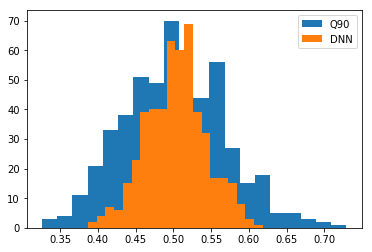

In [10]:
print("90%-quantile - Fréchet - MSE:", np.mean(np.power((gamma_hatF-test_labelsF),2)),
      ", MAE:", np.mean(np.abs((gamma_hatF-test_labelsF))))
evF=modelH.evaluate(test_dataFl, test_labelsF)
print("DNN - Fréchet - MSE:", evF[0], ", MAE:", evF[1])

plt.hist(gamma_hatF, bins=20, label="Q90")
plt.hist(modelH.predict(test_dataFl), bins=20, label="DNN")
legend = plt.legend()
plt.show()

90%-quantile - Cauchy - MSE: 0.0380056946315 , MAE: 0.15418273871
500/500 [==============================] - 0s 68us/step
DNN - Cauchy - MSE: 0.0295298090875 , MAE: 0.154257975101


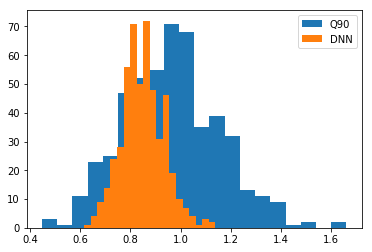

In [11]:
print("90%-quantile - Cauchy - MSE:", np.mean(np.power((gamma_hatC-test_labelsC),2)),
      ", MAE:", np.mean(np.abs((gamma_hatC-test_labelsC))))
evC=modelH.evaluate(test_dataCl, test_labelsC)
print("DNN - Cauchy - MSE:", evC[0], ", MAE:", evC[1])

plt.hist(gamma_hatC, bins=20, label="Q90")
plt.hist(modelH.predict(test_dataCl), bins=20, label="DNN")
legend = plt.legend()
plt.show()

## Considering different sample sizes

A major drawback of such a network is that the architecture determines the number of observations that can be processed. Thus, you would either train a seperate network for each sample sizes your are confronted with or you consider drawing from your data with replacement to obtain samples of the same size. The second approach makes sense, if you have a various samples whose sample size does not vary too much. <br>

To evaluate this idea, the test data generated in the following has different sample sizes, but in contrast to the 90%-quantile method the DNN is applied to resampled versions of size N.

In [12]:
M=500
dif=200 # sample sizes considered range from N-dif to N+dif

## Fréchet(2)
test_dataFlv=np.zeros((M,N))
test_dataFv=np.zeros((M,N+dif))
test_labelsFv=np.zeros(M)
    
for i in range(M):
    gamma=1/2
    Nr=np.random.randint(N-dif,N+dif)
    Xr=stat.invweibull.rvs(c=1/gamma, size=Nr)
    if Nr>=N:
        X=np.asarray(random.sample(list(Xr),N))
    else:
        X=np.zeros(N)
        for j in range(N):
            X[j]=random.choice(Xr)
    test_dataFlv[i,]=np.log(X)
    test_dataFv[i,:len(Xr)]=Xr
    test_labelsFv[i]=gamma
    
    
## Cauchy
test_dataClv=np.zeros((M,N))
test_dataCv=np.zeros((M,N+dif))
test_labelsCv=np.zeros(M)

for i in range(M):
    Nr=np.random.randint(N-dif,N+dif)
    Xr=np.random.standard_cauchy(size=Nr)
    if Nr>=N:
        X=np.asarray(random.sample(list(Xr),N))
    else:
        X=np.zeros(N)
        for j in range(N):
            X[j]=random.choice(Xr)
    test_dataClv[i,]=np.log(abs(X))
    test_dataCv[i,:len(Xr)]=Xr
    test_labelsCv[i]=1

In [13]:
gamma_hatFv=np.zeros(500)

for i in range(500):
    X=test_dataFv[i,][test_dataFv[i,]>0]
    k1=np.int_(np.floor(len(X[X>0])*0.1))
    gamma_hatFv[i]=hill(X,k1)
    
    
gamma_hatCv=np.zeros(500)

for i in range(500):
    X=test_dataCv[i,][test_dataCv[i,]>0]
    k1=np.int_(np.floor(len(X[X>0])*0.1))
    gamma_hatCv[i]=hill(X,k1)

90%-quantile - Fréchet - MSE: 0.00514669700271 , MAE: 0.0573332797615
500/500 [==============================] - 0s 73us/step
DNN - Fréchet - MSE: 0.00204296389408 , MAE: 0.0351358177066


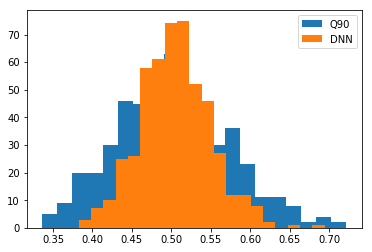

In [14]:
print("90%-quantile - Fréchet - MSE:", np.mean(np.power((gamma_hatFv-test_labelsFv),2)),
      ", MAE:", np.mean(np.abs((gamma_hatFv-test_labelsFv))))
evF=modelH.evaluate(test_dataFlv, test_labelsFv)
print("DNN - Fréchet - MSE:", evF[0], ", MAE:", evF[1])

plt.hist(gamma_hatFv, bins=20, label="Q90")
plt.hist(modelH.predict(test_dataFlv), bins=20, label="DNN")
legend = plt.legend()
plt.show()

90%-quantile - Cauchy - MSE: 0.0442833781292 , MAE: 0.168162100913
500/500 [==============================] - 0s 111us/step
DNN - Cauchy - MSE: 0.0317210486829 , MAE: 0.155647257328


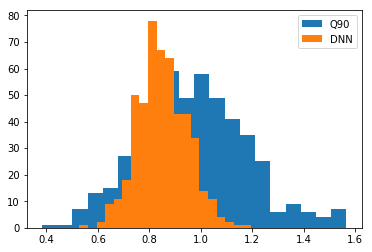

In [15]:
print("90%-quantile - Cauchy - MSE:", np.mean(np.power((gamma_hatCv-test_labelsCv),2)),
      ", MAE:", np.mean(np.abs((gamma_hatCv-test_labelsCv))))
evC=modelH.evaluate(test_dataClv, test_labelsCv)
print("DNN - Cauchy - MSE:", evC[0], ", MAE:", evC[1])

plt.hist(gamma_hatCv, bins=20, label="Q90")
plt.hist(modelH.predict(test_dataClv), bins=20, label="DNN")
legend = plt.legend()
plt.show()

Surprisingly the DNN does not suffer much from the resampling scheme and still peforms better than the 90%-quantile. Though, it is remarkable that the DNN leads to a negative bias when estimating $\gamma$ for the Cauchy distribution. This could be an interesting starting point for a deeper analysis on how the network functions.

## Conclusion

Training neural networks in order to learn the extreme value index without the necessary selection of a threshold or sample fraction seems worth further investigation. It would be very interesting to get insight on the structure of the network and understand how it actually performs this estimation, since we could possibly learn about hidden structures in the data exploited by the network.